# PSS3E20 EDA which makes sense 

Before starting the EDA, have a look at the home page of the [Sentinel-5P satellite](https://developers.google.com/earth-engine/datasets/catalog/sentinel-5p?hl=en), which has produced the dataset. The satellite measures the concentration of several gases in the air, and its data can be visualized in images such as this one, which shows the world-wide carbon monoxide concentration:

![Carbon monoxide](https://developers.google.com/static/earth-engine/images/datasets/copernicus_s5p_co_1280_720.jpg)

In [23]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib
import seaborn as sns
import statsmodels.tsa.holtwinters
from scipy.optimize import minimize
from colorama import Fore, Back, Style

import folium
import geopandas as gpd

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.decomposition import TruncatedSVD, NMF

np.set_printoptions(linewidth=95, edgeitems=5)


# Reading the data

In [24]:
train = pd.read_csv('../data/train.csv',
                    index_col='ID_LAT_LON_YEAR_WEEK')
test = pd.read_csv('../data/test.csv',
                   index_col='ID_LAT_LON_YEAR_WEEK')
train

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
ID_LAT_LON_YEAR_WEEK,,,,,,,,,,,,,,,,,,,,,
ID_-0.510_29.290_2019_00,-0.510,29.290,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,50.843559,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
ID_-0.510_29.290_2019_01,-0.510,29.290,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,39.137194,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
ID_-0.510_29.290_2019_02,-0.510,29.290,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,52.868816,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
ID_-0.510_29.290_2019_03,-0.510,29.290,2019,3,NaN,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
ID_-0.510_29.290_2019_04,-0.510,29.290,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,35.515587,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_-3.299_30.301_2021_48,-3.299,30.301,2021,48,0.000284,1.195643,0.000340,0.191313,72.820518,55.988022,...,5459.185355,60657.101913,4590.879504,20.245954,0.304797,-35.140368,40.113533,-129.935508,32.095214,29.404171
ID_-3.299_30.301_2021_49,-3.299,30.301,2021,49,0.000083,1.130868,0.000063,0.177222,-12.856753,19.435339,...,5606.449457,60168.191528,4659.130378,6.104610,0.314015,4.667058,47.528435,-134.252871,30.771469,29.186497
ID_-3.299_30.301_2021_50,-3.299,30.301,2021,50,NaN,NaN,NaN,NaN,NaN,NaN,...,6222.646776,56596.027209,5222.646823,14.817885,0.288058,-0.340922,35.328098,-134.731723,30.716166,29.131205


Every row of train contains four index columns (`latitude`, `longitude`, `year` and `week_no`), 70 features and a target (`emission`). The 70 features come in 8 groups of various sizes.

7 of the groups correspond to the main features (measurements) of the [data description page](https://www.kaggle.com/competitions/playground-series-s3e20/data):
<ul>
<li>Sulphur Dioxide - <a rel="noreferrer nofollow" target="_blank" href="https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_NRTI_L3_SO2?hl=en">COPERNICUS/S5P/NRTI/L3_SO2</a></li>
<li>Carbon Monoxide - <a rel="noreferrer nofollow" target="_blank" href="https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_NRTI_L3_CO?hl=en">COPERNICUS/S5P/NRTI/L3_CO</a></li>
<li>Nitrogen Dioxide - <a rel="noreferrer nofollow" target="_blank" href="https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_NRTI_L3_NO2?hl=en">COPERNICUS/S5P/NRTI/L3_NO2</a></li>
<li>Formaldehyde - <a rel="noreferrer nofollow" target="_blank" href="https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_NRTI_L3_HCHO?hl=en">COPERNICUS/S5P/NRTI/L3_HCHO</a></li>
<li>UV Aerosol Index - <a rel="noreferrer nofollow" target="_blank" href="https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_NRTI_L3_AER_AI?hl=en">COPERNICUS/S5P/NRTI/L3_AER_AI</a></li>
<li>Ozone - <a rel="noreferrer nofollow" target="_blank" href="https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_NRTI_L3_O3?hl=en">COPERNICUS/S5P/NRTI/L3_O3</a></li>
<li>Cloud - <a rel="noreferrer nofollow" target="_blank" href="https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_OFFL_L3_CLOUD?hl=en">COPERNICUS/S5P/OFFL/L3_CLOUD</a></li>
</ul>

Click on some of the links above - you'll learn something about how the data was measured and preprocessed and about missing values. All the seven description pages contain a `Bands` tab, which describes the subfeatures.

The eighth group has names starting with `UvAerosolLayerHeight`.

The following table has been taken from the [SO2 data description](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_NRTI_L3_SO2?hl=en#bands) and explains the SO2 subfeatures (the other features are similar):
<table class="eecat">
<tbody><tr>
<th scope="col">Name</th>
<th scope="col">Units</th>
<th scope="col">Min</th>
<th scope="col">Max</th>
<th scope="col">Description</th>
</tr>
<tr>
<td><code translate="no" dir="ltr">SO2_<wbr>column_<wbr>number_<wbr>density</code></td>
<td>mol/m^2</td>
<td>
          -48*
</td>
<td>
          0.24*
</td>
<td><p>SO<sub>2</sub> vertical column density at ground level,
calculated using the DOAS technique.</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">SO2_<wbr>column_<wbr>number_<wbr>density_<wbr>amf</code></td>
<td>mol/m^2</td>
<td>
          0.1*
</td>
<td>
          3.397*
</td>
<td><p>Weighted mean of cloudy and clear air mass factor (amf) weighted by
intensity-weighted cloud fraction.</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">SO2_<wbr>slant_<wbr>column_<wbr>number_<wbr>density</code></td>
<td>mol/m^2</td>
<td>
          -0.147*
</td>
<td>
          0.162*
</td>
<td><p>SO<sub>2</sub> ring corrected slant column number density</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">cloud_<wbr>fraction</code></td>
<td>Fraction</td>
<td>
          0*
</td>
<td>
          1*
</td>
<td><p>Effective cloud fraction.  See the <a href="https://sentinels.copernicus.eu/documents/247904/3119978/Sentinel-5P-Level-2-Input-Output-Data-Definition">Sentinel 5P L2 Input/Output Data Definition Spec</a>,
p.220.</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">sensor_<wbr>azimuth_<wbr>angle</code></td>
<td>deg</td>
<td>
          -180*
</td>
<td>
          180*
</td>
<td><p>Azimuth angle of the satellite at the ground pixel location (WGS84); angle
measured East-of-North.</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">sensor_<wbr>zenith_<wbr>angle</code></td>
<td>deg</td>
<td>
          0.09*
</td>
<td>
          67*
</td>
<td><p>Zenith angle of the satellite at the ground pixel location (WGS84); angle
measured away from the vertical.</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">solar_<wbr>azimuth_<wbr>angle</code></td>
<td>deg</td>
<td>
          -180*
</td>
<td>
          180*
</td>
<td><p>Azimuth angle of the Sun at the ground pixel location (WGS84); angle
measured East-of-North.</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">solar_<wbr>zenith_<wbr>angle</code></td>
<td>deg</td>
<td>
          8*
</td>
<td>
          80*
</td>
<td><p>Zenith angle of the satellite at the ground pixel location (WGS84); angle
measured away from the vertical.</p></td>
</tr>
<tr>
<td><code translate="no" dir="ltr">SO2_<wbr>column_<wbr>number_<wbr>density_<wbr>15km</code></td>
<td>mol/m^2</td>
<td>
</td>
<td>
</td>
<td><p>SO<sub>2</sub> vertical column density at 15km,
calculated using the DOAS technique.</p></td>
</tr>
</tbody></table>

The groups contain different subfeatures, but four subfeatures appear in every group:
- 'sensor_azimuth_angle',
- 'sensor_zenith_angle',
- 'solar_azimuth_angle',
- 'solar_zenith_angle',

The subfeatures are necessary to interpret the measurements. As the data was measured by a satellite which is not directly above the measured location, the angle of the satellite affects the measurement. The measurements are further influenced by the angle of the sun and by clouds.

The following list shows the names of all 75 training columns:

In [25]:
for i, f in enumerate(train.columns):
    print(f"{i:2}: {f}")

 0: latitude
 1: longitude
 2: year
 3: week_no
 4: SulphurDioxide_SO2_column_number_density
 5: SulphurDioxide_SO2_column_number_density_amf
 6: SulphurDioxide_SO2_slant_column_number_density
 7: SulphurDioxide_cloud_fraction
 8: SulphurDioxide_sensor_azimuth_angle
 9: SulphurDioxide_sensor_zenith_angle
10: SulphurDioxide_solar_azimuth_angle
11: SulphurDioxide_solar_zenith_angle
12: SulphurDioxide_SO2_column_number_density_15km
13: CarbonMonoxide_CO_column_number_density
14: CarbonMonoxide_H2O_column_number_density
15: CarbonMonoxide_cloud_height
16: CarbonMonoxide_sensor_altitude
17: CarbonMonoxide_sensor_azimuth_angle
18: CarbonMonoxide_sensor_zenith_angle
19: CarbonMonoxide_solar_azimuth_angle
20: CarbonMonoxide_solar_zenith_angle
21: NitrogenDioxide_NO2_column_number_density
22: NitrogenDioxide_tropospheric_NO2_column_number_density
23: NitrogenDioxide_stratospheric_NO2_column_number_density
24: NitrogenDioxide_NO2_slant_column_number_density
25: NitrogenDioxide_tropopause_pressur

**Insight:**
1. The satellite measures the concentration of several gases in the atmosphere, but it does not measure CO2. Our task is to predict the CO2 emission for every location and point in time based on the concentration of the other gases.
2. We do not know how the CO2 emissions were measured. They are not measured by the Sentinel-5P satellite. They could be measured by stations on the ground or by some other satellite.


# Completeness of the data

We see that
- There are 497 geographical points (latitude-longitude pairs). The points are the same in train and test.
- For every geographical point, there are 159 rows with observations in train and 49 rows in test.
- The 159 training rows correspond to three years (2019, 2020, 2021) with 53 weeks each (numbered from 0 to 52).
- The 49 test rows correspond to weeks 0 to 48 of 2022.
- 497 \* 3 \* 53 = 79023, the size of the training dataset.
- 497 * 49 = 24353, the size of the test set.

In [26]:
print(train.groupby(['latitude', 'longitude']).size().sort_values())
print()
print(test.groupby(['latitude', 'longitude']).size().sort_values())
print()
print(pd.concat([train, test], axis=0).groupby(['latitude', 'longitude']).size().sort_values())


latitude  longitude
-3.299    30.301       159
-1.444    30.856       159
-1.450    29.350       159
-1.482    30.618       159
-1.486    29.614       159
                      ... 
-2.293    29.507       159
-2.300    29.200       159
-2.301    29.899       159
-2.257    30.243       159
-0.510    29.290       159
Length: 497, dtype: int64

latitude  longitude
-3.299    30.301       49
-1.444    30.856       49
-1.450    29.350       49
-1.482    30.618       49
-1.486    29.614       49
                       ..
-2.293    29.507       49
-2.300    29.200       49
-2.301    29.899       49
-2.257    30.243       49
-0.510    29.290       49
Length: 497, dtype: int64

latitude  longitude
-3.299    30.301       208
-1.444    30.856       208
-1.450    29.350       208
-1.482    30.618       208
-1.486    29.614       208
                      ... 
-2.293    29.507       208
-2.300    29.200       208
-2.301    29.899       208
-2.257    30.243       208
-0.510    29.290       208
Length

We can plot a scatterplot of the 497 points. The latitudes are negative, which means that the points are south of the equator.

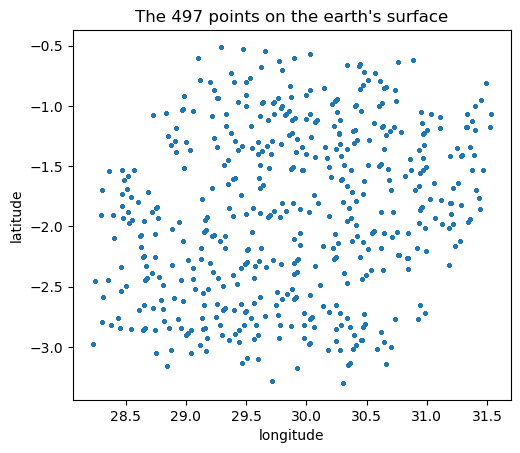

In [27]:
plt.title("The 497 points on the earth's surface")
plt.scatter(train.longitude, train.latitude, s=3)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.gca().set_aspect('equal')
plt.show()

The plot looks much nicer if we plot the points on a map:

In [28]:
# Taken from https://www.kaggle.com/code/inversion/getting-started-eda

train_coords = train.drop_duplicates(subset = ['latitude', 'longitude'])
geometry = gpd.points_from_xy(train_coords.longitude, train_coords.latitude)
geo_df = gpd.GeoDataFrame(
    train_coords[["latitude", "longitude"]], geometry=geometry
)

# Create a canvas to plot your map on
all_data_map = folium.Map(prefer_canvas=True)

# Create a geometry list from the GeoDataFrame
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry]

# Iterate through list and add a marker for each location
for coordinates in geo_df_list:

    # Place the markers 
    all_data_map.add_child(
        folium.CircleMarker(
            location=coordinates,
            radius = 1,
            weight = 4,
            zoom =10,
            color =  "red"),
        )
all_data_map.fit_bounds(all_data_map.get_bounds())
all_data_map

AttributeError: module 'geopandas' has no attribute 'points_from_xy'

**Insight:**
- As we are working with **geographical data**, measurements of nearby locations can help to predict the target.
- A good machine learning model will not simply take the 74 features of every row to predict the target, but use the features of nearby locations to improve the predictions.
- The data is a **time series**. Measurements of earlier points in time may help to predict the current point.

# Missing values
- Except for the index columns (`latitude`, `longitude`, `year` and `week_no`) and the target (`emission`), every column has missing values.
- Some colunms (e.g., `UvAerosolLayerHeight_aerosol_pressure`) have almost only missing values (78584 of 79023):

In [ ]:
with pd.option_context("display.min_rows", 14):
    display(train.isna().sum().sort_values())
print()
with pd.option_context("display.min_rows", 14):
    display(test.isna().sum().sort_values())

latitude                                          0
week_no                                           0
emission                                          0
longitude                                         0
year                                              0
Cloud_solar_zenith_angle                        484
Cloud_cloud_top_pressure                        484
                                              ...  
UvAerosolLayerHeight_sensor_zenith_angle      78584
UvAerosolLayerHeight_solar_azimuth_angle      78584
UvAerosolLayerHeight_sensor_azimuth_angle     78584
UvAerosolLayerHeight_aerosol_optical_depth    78584
UvAerosolLayerHeight_aerosol_height           78584
UvAerosolLayerHeight_solar_zenith_angle       78584
UvAerosolLayerHeight_aerosol_pressure         78584
Length: 75, dtype: int64

latitude                                          0
longitude                                         0
year                                              0
week_no                                           0
UvAerosolIndex_sensor_altitude                  147
UvAerosolIndex_sensor_azimuth_angle             147
UvAerosolIndex_sensor_zenith_angle              147
                                              ...  
UvAerosolLayerHeight_solar_azimuth_angle      22260
UvAerosolLayerHeight_sensor_azimuth_angle     22260
UvAerosolLayerHeight_sensor_zenith_angle      22260
UvAerosolLayerHeight_aerosol_optical_depth    22260
UvAerosolLayerHeight_aerosol_pressure         22260
UvAerosolLayerHeight_solar_zenith_angle       22260
UvAerosolLayerHeight_aerosol_height           22260
Length: 74, dtype: int64

Values are missing if during a whole week the satellite never could make a reliable measurement for a location, for instance because of clouds or because it never saw the location from a good angle. The next notebook cell shows a row from the training data without measurements for SO2, NO2, Formaldehyde and UvAerosolLayerHeight.

In [ ]:
with pd.option_context("display.max_rows", 100):
    print(train.loc['ID_-0.510_29.290_2019_03'])

latitude                                                        -0.510000
longitude                                                       29.290000
year                                                          2019.000000
week_no                                                          3.000000
SulphurDioxide_SO2_column_number_density                              NaN
SulphurDioxide_SO2_column_number_density_amf                          NaN
SulphurDioxide_SO2_slant_column_number_density                        NaN
SulphurDioxide_cloud_fraction                                         NaN
SulphurDioxide_sensor_azimuth_angle                                   NaN
SulphurDioxide_sensor_zenith_angle                                    NaN
SulphurDioxide_solar_azimuth_angle                                    NaN
SulphurDioxide_solar_zenith_angle                                     NaN
SulphurDioxide_SO2_column_number_density_15km                         NaN
CarbonMonoxide_CO_column_number_densit

**Insight:**
- We need a way to handle missing data. As data is missing in train and test, we cannot simply drop rows with missing data, but need to impute the missing values.
- As we are working with geographical data, measurements of nearby locations can be used for imputing missing values.
- As the data is a time series, measurements of nearby points in time can be used for imputing missing values.


# Target value distribution

The histogram suggests that the target (`emission`) is exponentially distributed:

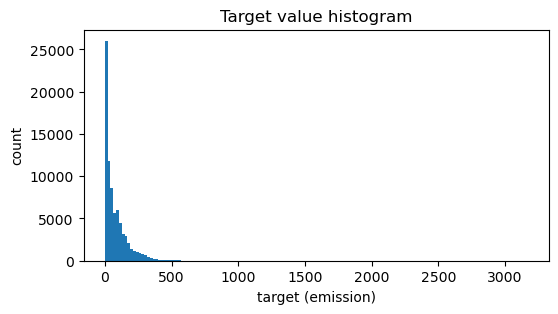

In [ ]:
plt.figure(figsize=(6, 3))
plt.hist(train.emission, bins=150)
plt.title('Target value histogram')
plt.xlabel('target (emission)')
plt.ylabel('count')
plt.show()

There are public notebooks in this competition which suggest to treat the skewed target distribution with techniques such as log transform, box-cox transform or square root transform. I strongly advise against these transformations! 

**Insight:** The target must not be transformed: The competition is scored on root mean squared error (RMSE), and the usual target transformations make it very hard to optimize RMSE.

Next, we'll look at the mean target value per location. We see:
- Several locations have a mean emission of zero, and because there are no negative emissions, their emission is constantly at zero. These locations will be easy to predict 🙂
- Even the distribution of the mean emission per location looks like an exponential distribution.

In [ ]:
train.groupby(['latitude', 'longitude']).emission.mean().sort_values()

latitude  longitude
-1.682    29.218          0.000000
-2.859    29.041          0.000000
-1.833    28.467          0.000000
-2.841    29.159          0.000000
-1.974    28.526          0.000000
                          ...     
-1.342    31.358        409.606870
-0.956    30.744        455.398039
-1.346    31.254        475.289138
-2.079    29.321       1221.886518
-2.378    29.222       2233.431628
Name: emission, Length: 497, dtype: float64

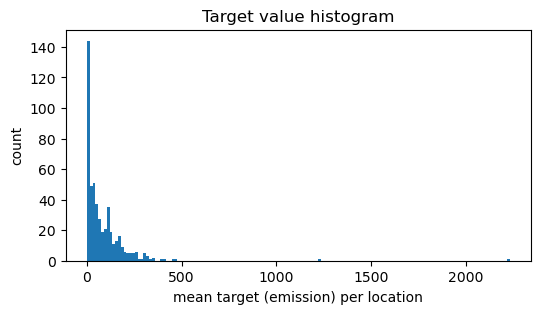

In [ ]:
plt.figure(figsize=(6, 3))
plt.hist(train.groupby(['latitude', 'longitude']).emission.mean(), bins=150)
plt.title('Target value histogram')
plt.xlabel('mean target (emission) per location')
plt.ylabel('count')
plt.show()

Let's plot the mean emission per location on the map. The emissions are color-coded: blue = low emission; red = high emission. We see that the emissions are clustered:
- Points in the west (Democratic Republic of the Congo) all have low emissions.
- The two red points with the highest emissions are both near Lac Kivu.

In [ ]:
def rgba_to_hex(color):
    """Return color as #rrggbb for the given color values."""
    red, green, blue, alpha = color
    return f"#{int(red*255):02x}{int(green*255):02x}{int(blue*255):02x}"

temp = train.groupby(['latitude', 'longitude']).emission.mean().reset_index()
geometry = gpd.points_from_xy(temp.longitude, temp.latitude)

cmap = matplotlib.colormaps['coolwarm']
normalizer = matplotlib.colors.Normalize(vmin=np.log1p(temp.emission.min()), vmax=np.log1p(temp.emission.max()))

# Create a canvas to plot your map on
all_data_map = folium.Map(prefer_canvas=True)

# Create a geometry list from the GeoDataFrame
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geometry]

# Iterate through list and add a marker for each location
for coordinates, emission in zip(geo_df_list, temp.emission):
#     print(emission, normalizer(emission), rgba_to_hex(cmap(normalizer(emission))))
    # Place the markers 
    all_data_map.add_child(
        folium.CircleMarker(
            location=coordinates,
            radius = 1,
            weight = 4,
            zoom =10,
            color = rgba_to_hex(cmap(normalizer(np.log1p(emission))))),
        )
all_data_map.fit_bounds(all_data_map.get_bounds())
all_data_map

Next, we'll plot the time series of the emissions for every location. The plot shows
1. The two locations with very high emissions have special patterns (red and gray); all other locations look similar.
2. Seasonality: There are yearly patterns (which repeat every 53 weeks).

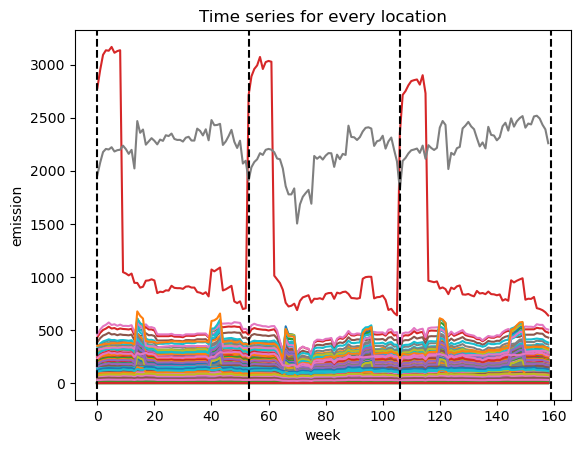

In [ ]:
for ll in train[['latitude', 'longitude']].drop_duplicates().iterrows():
    time_series = train[(train.latitude == ll[1].latitude) & (train.longitude == ll[1].longitude)].emission
    plt.plot(range(len(time_series)), time_series)
plt.title('Time series for every location')
for week in [0, 53, 106, 159]:
    plt.axvline(week, color='k', linestyle='--')
plt.xlabel('week')
plt.ylabel('emission')
plt.show()


We can try to identify trends in the emission data. The following diagram shows that the CO2 emissions of most locations got smaller from 2019 to 2020, presumably because of Covid, but increased again from 2020 to 2021. The big question is how this should be extrapolated to 2022...

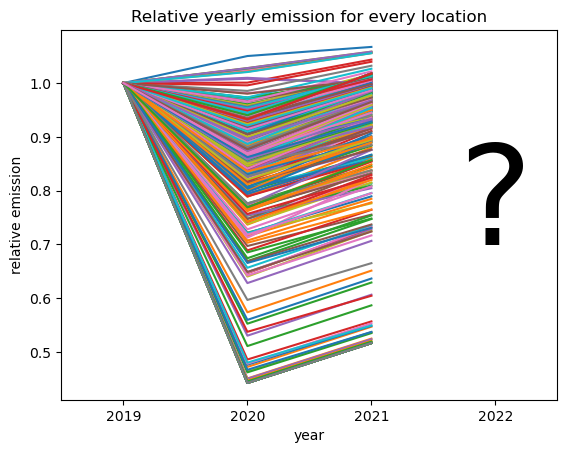

In [ ]:
for ll in train[['latitude', 'longitude']].drop_duplicates().iterrows():
    time_series = train[(train.latitude == ll[1].latitude) & (train.longitude == ll[1].longitude)].groupby('year').emission.mean()
    time_series = time_series / time_series.loc[2019]
    plt.plot(time_series.index, time_series)
plt.title('Relative yearly emission for every location')
plt.xlabel('year')
plt.ylabel('relative emission')
plt.xlim(2018.5, 2022.5)
plt.text(2022, 0.7, '?', fontsize=100, ha='center')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()


# Feature distributions

At this point in the notebook, you might expect an analysis of the features.

To make it short: **The satellite measurements are useless.** These features are terribly noisy and unrelated to the target. A satellite measurement applies only to a single point in time whereas the targets are the CO2 emissions of a whole week. The time of the measurement is determined by the satellite's orbit. Its result depends on clouds, temperature, volcano eruptions and other factors. Furthermore, CO2 emissions come from different sectors (ground traffic, heating, power generation, air traffic, …), and these sectors don't contribute proportionally to NO2, CO or SO2. With a diameter of 200 km, Rwanda is a small country, and the wind replaces Rwanda's whole atmosphere with air from neighboring countries every day.

We'll skip the analysis of these data and note that without the satellite measurements, we have only four features left: latitude, longitude, year and week_no.

# Baseline model

Let's create a very simple baseline model, which only uses the location and the yearly pattern for prediction, i.e., it doesn't look at the satellite's measurements and it doesn't extrapolate any trend. This model doesn't need to impute values because the location and the week are always known. Its prediction for every location and week is simply the average of the emissions of the past years for the same location and week.

You don't need any fancy model for that; a `DecisionTreeRegressor` or a `RadiusNeighborsRegressor(radius=0)` is enough (and both give the same result).

In this competition, we have to predict the year 2022 based on the year 2019, 2020 and 2021. To simulate this prediction task, I'm using `LeaveOneGroupOut` for cross-validation so that the model is trained on two years to predict the third one.

In [ ]:
score_list = []
kf = LeaveOneGroupOut()
for fold, (idx_tr, idx_va) in enumerate(kf.split(train, groups=train.year)):
    X_tr = train.iloc[idx_tr][['longitude', 'latitude', 'week_no']]
    y_tr = train.iloc[idx_tr]['emission']
    X_va = train.iloc[idx_va][['longitude', 'latitude', 'week_no']]
    y_va = train.iloc[idx_va]['emission']

    model = RadiusNeighborsRegressor(radius=0) # or DecisionTreeRegressor()
    model.fit(X_tr, y_tr)
    y_va_pred = model.predict(X_va)
    rmse = mean_squared_error(y_va, y_va_pred, squared=False)
    print(f"Fold {fold} year {train.iloc[idx_va].year.iloc[0]}: rmse = {rmse:.2f}")
    score_list.append(rmse)

rmse = sum(score_list) / len(score_list)
print(f"Overall RMSE: {rmse:.2f}")

Fold 0 year 2019: rmse = 20.29
Fold 1 year 2020: rmse = 27.14
Fold 2 year 2021: rmse = 19.77
Overall RMSE: 22.40


The baseline model suggests that it is easy to get a score around 22. This score is better than the 27.47 cv score of the official [Getting Started: Modeling](https://www.kaggle.com/code/inversion/getting-started-modeling) notebook, which uses a random forest. The scores are not directly comparable, though, because they are based on different train-test splits.

Note that the year 2020 (RMSE 27) is harder to predict than 2019 (RMSE 20) and 2021 (RMSE 19). 

In [ ]:
model = RadiusNeighborsRegressor(radius=0) # or DecisionTreeRegressor()
model.fit(train[['longitude', 'latitude', 'week_no']], train.emission)
y_pred = model.predict(test[['longitude', 'latitude', 'week_no']])
submission_standard = pd.Series(y_pred, name='emission', index=test.index)
submission_standard.to_csv('submission_standard.csv')
submission_standard

ID_LAT_LON_YEAR_WEEK
ID_-0.510_29.290_2022_00     3.608051
ID_-0.510_29.290_2022_01     4.016319
ID_-0.510_29.290_2022_02     4.138755
ID_-0.510_29.290_2022_03     4.184737
ID_-0.510_29.290_2022_04     4.247569
                              ...    
ID_-3.299_30.301_2022_44    28.725407
ID_-3.299_30.301_2022_45    29.048892
ID_-3.299_30.301_2022_46    29.252211
ID_-3.299_30.301_2022_47    29.794027
ID_-3.299_30.301_2022_48    28.759248
Name: emission, Length: 24353, dtype: float64

@oscarm524 has [implemented the same idea in a slightly different way](https://www.kaggle.com/code/oscarm524/ps-s3-ep20-eda-modeling-submission/notebook?scriptVersionId=138618281), got the same predictions (you can compare his [submission file](https://www.kaggle.com/code/oscarm524/ps-s3-ep20-eda-modeling-submission/output?scriptVersionId=138618281)), submitted them and got a leaderboard score of 33.35922.

This high RMSE suggests that either the year 2022 is even harder to predict than 2020 (RMSE 27) or that our method misses something important.

# What the lockdown implies for cross-validation

The lockdown was a singular event: Nobody could foresee the lockdown. Do you expect that machine learning can predict the lockdown? Of course not! This means that cross-validating a machine-learning model on a validation set which contains the year 2020 is nonsense.

The lockdown hinders not only validation: What happens if the training dataset contains the lockdown period? Do we want our model to learn that the emissions of week 10 can be drastically lower than the emissions of week 9? No: Although such a reduction occurred in week 10 of 2020, it doesn't occur in week 10 of 2022, and we're using our model only for predicting 2022.

**Insight:**
- Cross-validation with `LeaveOneGroupOut` is meaningless: Nobody can predict the lockdown in 2020 after fitting a model to 2019 and 2021. Nobody can predict that there was no lockdown in 2019 after fitting a model to 2020 and 2021.
- CO2 emissions measured during the lockdown must be treated as outliers. They are useless for training a model.
- There is only one meaningful train–test split in this competition: Train on 2019, 2020 and perhaps part of 2021, and validate on the rest of 2021. This is the only feasible task — if you have data about the normal state (pre-lockdown) and the start of the recovery phase (post-lockdown), you can try to predict how the recovery continues.



# Extrapolating the trend

Our baseline model doesn't take into account that the time series could have a trend: Maybe Rwanda has constant economic growth, maybe they successfully reduce their carbon dioxide emissions, or the country is still recovering from Covid in 2022. Considering these possibilities, predicting the average of the three preceding years is not the best approach.

The following diagrams show, for every quarter of 2020 and 2021, how much the emissions have grown compared to the same quarter of the previous year. Every dot corresponds to a location. The x axis shows the average emission of the location, and the y axis shows how much the emission has grown (or shrunk). The lines in the diagrams are regression lines which serve to estimate the annual growth rate.

We can clearly identify the Corona effect: Q2/2020 has 23 % lower emissions than Q2/2019. A year later, Corona is overcome: Q2/2021 has 25 % higher emissions than Q2/2020.


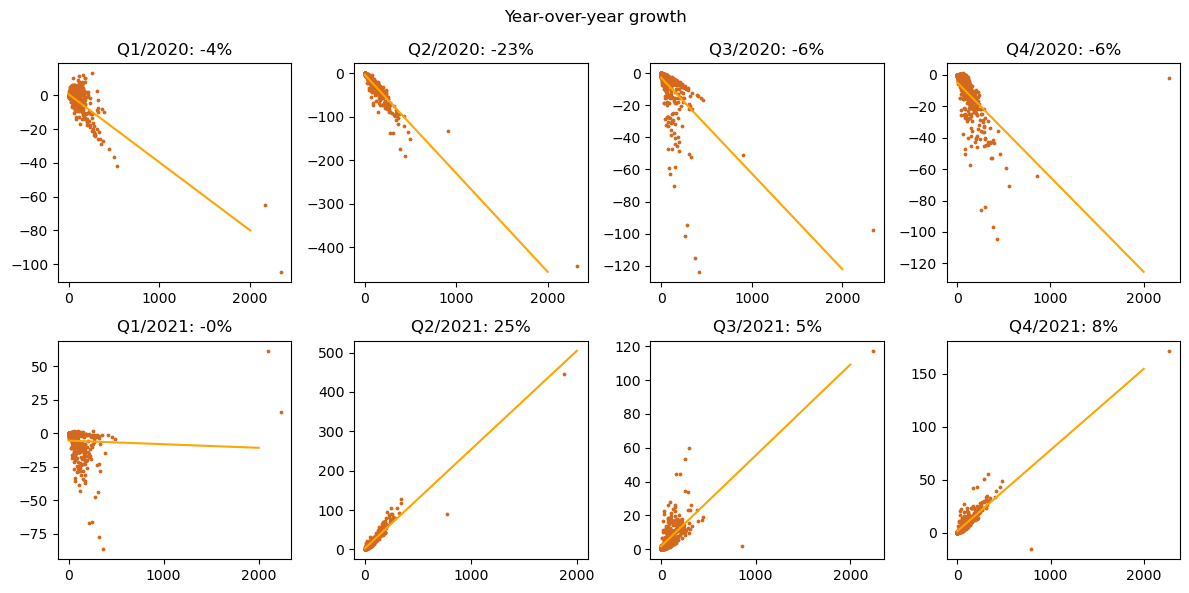

In [ ]:
temp = train.copy()
temp['quarter'] = temp['week_no'] // 14 + 1
grouped = temp.groupby(['longitude', 'latitude', 'year', 'quarter'])[['emission']].mean()
grouped = grouped.unstack(['longitude', 'latitude'])
delta = 4
one_year_difference = grouped.shift(-delta) - grouped

n_diagrams = 8
_, axs = plt.subplots(2, 4, figsize=(12, 6))
for i in range(n_diagrams):
    ax = axs.ravel()[i]
    ax.scatter(grouped.iloc[i], one_year_difference.iloc[i], c='chocolate', s=3)
    lr = LinearRegression()
    lr.fit(grouped.iloc[i].values.reshape(-1, 1), one_year_difference.iloc[i])
    xs = np.array([[0], [2000]])
    y_pred = lr.predict(xs)
    ax.plot(xs, y_pred, color='orange')
    index = grouped.index[i+delta]
    ax.set_title(f"Q{index[1]}/{index[0]}: {lr.coef_[0]:1.0%}")
    ax.set_xticks([0, 1000, 2000])
plt.suptitle('Year-over-year growth')
plt.tight_layout()
# plt.savefig('growth.png', bbox_inches='tight')
plt.show()

The final two quarters of the training data show annual growth rates of 5 % and 8 %. May we assume that the emissions will continue growing in 2022?

In the following cell we retrain our model on the full training data. The model predicts the average emissions of 2019-2021, which are exceptionally low because of Covid. It is therefore a legitimate attempt at extrapolation if we add 5 % to these predictions before submitting. 

There are a few subtleties to consider, though:
- The Covid effect is particularly strong in Q2. The Q2 predictions should probably get a higher adjustment than the rest.
- The diagrams above show how badly linear regression behaves when there are outliers. In the diagrams for Q4/2020 and Q1/2021, you can see how one or two outliers lead to a completely wrong regression line and to bad estimates for the annual growth rate.
- As @ravi20076 has found out, the public leaderboard [consists of the first 20 weeks of 2022](https://www.kaggle.com/competitions/playground-series-s3e20/discussion/428405). The growth rate for the rest of 2022 will likely differ from the one for the first 20 weeks.
- Maybe the trend shouldn't be extrapolated at all, but determined from the satellite observations. Covid should have had an effect on SO2, NO2 and other concentrations, and these concentrations, measured in 2022, should reveal the correct trend for the CO2 emissions. 

**Insight:**
- Try to use the satellite observations to determine the trend of the emissions - maybe not per location, but just as an overall trend.
- Extrapolate the time series through guessing only if the satellite observations don't reveal the trend.

In [ ]:
# Extrapolation of the growth trend - feel free to change the factor
submission_plus5 = submission_standard * 1.05
submission_plus5.to_csv('submission_plus5.csv')
submission_plus5

ID_LAT_LON_YEAR_WEEK
ID_-0.510_29.290_2022_00     3.788453
ID_-0.510_29.290_2022_01     4.217135
ID_-0.510_29.290_2022_02     4.345693
ID_-0.510_29.290_2022_03     4.393974
ID_-0.510_29.290_2022_04     4.459947
                              ...    
ID_-3.299_30.301_2022_44    30.161677
ID_-3.299_30.301_2022_45    30.501336
ID_-3.299_30.301_2022_46    30.714822
ID_-3.299_30.301_2022_47    31.283728
ID_-3.299_30.301_2022_48    30.197210
Name: emission, Length: 24353, dtype: float64

# Without extrapolation

I admit that manually adjusting predictions may not be the most scientific method. As an alternative, let's simply drop the 53 weeks most affected by Covid as outliers:

In [ ]:
# Drop the covid weeks as outliers
train_nocovid = train[(train.year == 2019) |
                       (train.year == 2020) & (train.week_no <= 8) |
                       (train.year == 2021) & (train.week_no > 8)]

model = DecisionTreeRegressor()
model.fit(train_nocovid[['longitude', 'latitude', 'week_no']], train_nocovid.emission)
y_pred = model.predict(test[['longitude', 'latitude', 'week_no']])
submission_nocovid = pd.Series(y_pred, name='emission', index=test.index)
submission_nocovid.to_csv('submission_nocovid.csv')
submission_nocovid

ID_LAT_LON_YEAR_WEEK
ID_-0.510_29.290_2022_00     3.752297
ID_-0.510_29.290_2022_01     4.038571
ID_-0.510_29.290_2022_02     4.192749
ID_-0.510_29.290_2022_03     4.235518
ID_-0.510_29.290_2022_04     4.290476
                              ...    
ID_-3.299_30.301_2022_44    29.836845
ID_-3.299_30.301_2022_45    30.249885
ID_-3.299_30.301_2022_46    30.432125
ID_-3.299_30.301_2022_47    30.868620
ID_-3.299_30.301_2022_48    29.674269
Name: emission, Length: 24353, dtype: float64

Let's compare the three predictions for the test set in a diagram:
- `standard` is based on the full training set, without any extrapolation. Most of the time, these predictions are too low.
- `plus5` corresponds to the standard predictions increased by 5 %.
- `nocovid` is the result of dropping the Covid weeks in the training data as outliers. These predictions are sometimes higher, sometimes lower than the `plus5` predictions. I'd trust these predictions the most.

@danbraswell has invented another method of dealing with the Covid outliers: Assuming that the Covid emissions are always lower than the regular ones, he published a notebook which simply predicts the maximum emissions over the three years: [No ML; public LB 23.02231](https://www.kaggle.com/code/danbraswell/no-ml-public-lb-23-02231).

**Insight:**
- We don't need to extrapolate. Dropping outliers may be the better method.
- The peculiarity of this competition (only three years of training data, of which one is barely usable) forces us to be creative.

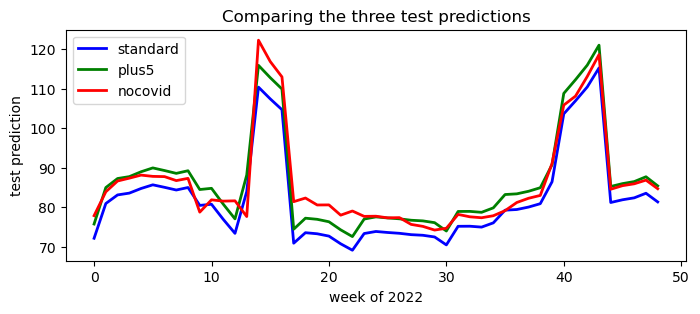

In [ ]:
plt.figure(figsize=(8, 3))
plt.title("Comparing the three test predictions")
plt.xlabel('week of 2022')
plt.ylabel('test prediction')
plt.plot(range(49), submission_standard.groupby(test.week_no).mean(), label='standard', lw=2, color='b')
plt.plot(range(49), submission_plus5.groupby(test.week_no).mean(), label='plus5', lw=2, color='g')
plt.plot(range(49), submission_nocovid.groupby(test.week_no).mean(), label='nocovid', lw=2, color='r')
plt.legend()
# plt.savefig('comparison.png', bbox_inches='tight')
plt.show()

# Dimensionality reduction

As a part of EDA, many data scientists look for correlations between features (or more general, for linear dependencies). If they find high correlations, they drop features or reduce the dimensionality of the data by some other method.

For our CO2 emission dataset, we take a different approach. There are 497 locations. Do you expect the CO2 measurements for the 497 locations to be all independent? Probably not. Several phenomena could cause dependence between measurements from different locations:
1. If wind and atmospheric turbulence are strong enough, nearby locations basically measure the same air, and the measurement results should be similar.
2. If economical and political phenomena affect the CO2 emissions, the effect will be the similar over the whole country.
3. (Seasonal) natural phenomena such as growth of plants, dominant wind, rainy season or [volcanoes](https://www.kaggle.com/competitions/playground-series-s3e20/discussion/429232) affect the whole country similarly.

The dependencies between emissions do not necessarily relate to the distances between their locations: Maybe the locations have different emission patterns because some sensors are placed in cities and others in the forest. We could analyze such dependencies by clustering the time series of the locations. (For an example of how the locations can be clustered, see @patrick0302's notebook [Clustering might help😎](https://www.kaggle.com/code/patrick0302/clustering-might-help))

For now, I want to see the linear dependencies between locations. To start, we reshape the data into a pivot table of emissions which has one row for every location and one column for every week of the training data. In other words, every row is the time series of a location:


In [ ]:
emission = train.pivot(index=['latitude', 'longitude'], 
                       columns=['year', 'week_no'], values='emission')
with pd.option_context("display.max_columns", 6, "display.max_rows", 6):
    display(emission)

year                     2019                        ...       2021  \
week_no                    0          1          2   ...         50   
latitude longitude                                   ...              
-3.299   30.301     26.111166  28.045977  29.293518  ...  29.131205   
-3.287   29.713     39.696404  43.529408  45.993286  ...  46.808056   
-3.174   29.926     41.193130  43.877285  45.760826  ...  45.675720   
...                       ...        ...        ...  ...        ...   
-0.547   29.653      0.500023   0.529315   0.554183  ...   0.618269   
-0.528   29.472      3.857115   4.213432   4.451489  ...   4.683615   
-0.510   29.290      3.750994   4.025176   4.231381  ...   4.607418   

year                                      
week_no                    51         52  
latitude longitude                        
-3.299   30.301     28.125792  27.239302  
-3.287   29.713     44.268930  43.260082  
-3.174   29.926     44.668972  42.904007  
...                       ...        ...  
-0.547   29.653      0.609128   0.575292  
-0.528   29.472      4.450044   4.318747  
-0.510   29.290      4.470275   4.269510  

[497 rows x 159 columns]

In the next step, we apply a [singular value decomposition (SVD)](https://scikit-learn.org/stable/modules/decomposition.html#lsa) to the data. (You could use a [PCA](https://scikit-learn.org/stable/modules/decomposition.html#pca) or [ICA](https://scikit-learn.org/stable/modules/decomposition.html#ica) and get similar results).

We plot the [cumulative explained variance](https://www.google.com/search?client=firefox-b-d&q=cumulative+explained+variance), and surprisingly the first five components explain almost all the variance. This is quite remarkable: It means that the emissions of the 495 locations all are linear combinations of the emissions of only five basis locations!

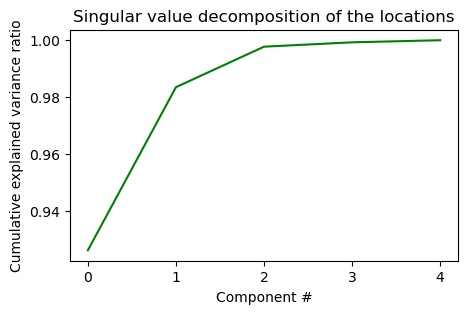

In [ ]:
svd = TruncatedSVD(n_components=5)
svd.fit(emission)

plt.figure(figsize=(5, 3))
plt.plot(svd.explained_variance_ratio_.cumsum(), color='g')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('Singular value decomposition of the locations')
plt.ylabel('Cumulative explained variance ratio')
plt.xlabel('Component #')
plt.show()

A heatmap of the five singular vectors shows some patterns:
- Vector 1 shows seasonal peaks every January and February.
- Vector 2 shows seasonal peaks in May and October.
- Vector 3 shows a sudden change in emissions around week 8 of 2020. This is the Covid effect.

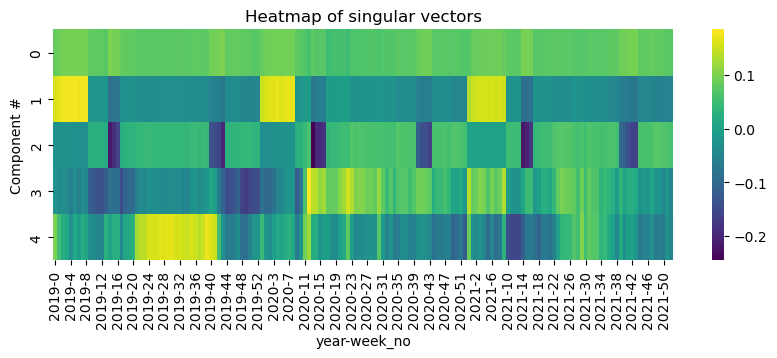

In [ ]:
plt.figure(figsize=(10, 3))
sns.heatmap(pd.DataFrame(svd.components_, columns=emission.columns), cmap='viridis')
plt.ylabel('Component #')
plt.title('Heatmap of singular vectors')
plt.show()


We now project the 495 locations to the first two principal components and mark four representative locations:

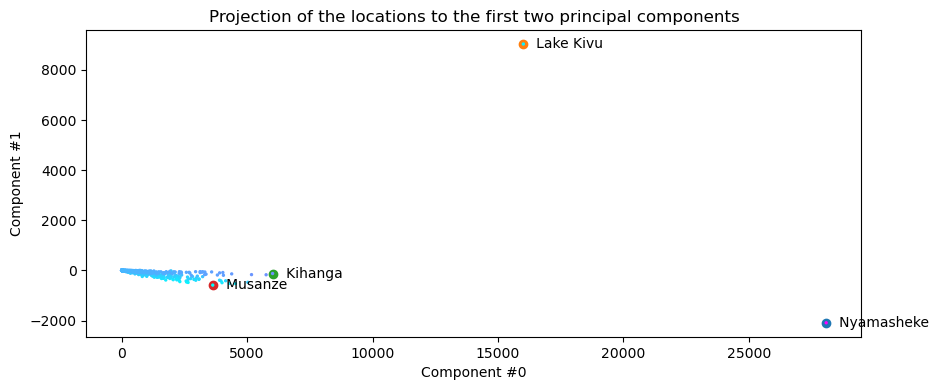

In [ ]:
# Special locations (latitude, longitude)
named_loc = {'Nyamasheke': (-2.378, 29.222),
             'Lake Kivu': (-2.079, 29.321),
             'Kihanga': (-1.346, 31.254),
             'Musanze': (-1.514, 29.686),
            }

embedding = pd.DataFrame(svd.fit_transform(emission), index=emission.index) # 5 columns
denoised_emission = pd.DataFrame(svd.inverse_transform(embedding),
                                columns=emission.columns,
                                index=emission.index)
cx, cy, cc = 0, 1, 2
plt.figure(figsize=(10, 10))
plt.gca().set_aspect('equal')
for name, coord in named_loc.items():
    plt.scatter(embedding.loc[coord].values[[cx]], embedding.loc[coord].values[[cy]])
    plt.text(embedding.loc[coord].values[[cx]],
             embedding.loc[coord].values[[cy]], 
             '   ' + name,
             va='center')
plt.scatter(embedding.values.T[cx], embedding.values.T[cy], s=2,
            c=embedding.values.T[cc], cmap='cool')
plt.title('Projection of the locations to the first two principal components')
plt.xlabel(f'Component #{cx}')
plt.ylabel(f'Component #{cy}')
plt.show()


The four marked locations are special indeed:
- Nyamasheke has the highest average emission.
- Lake Kivu has high peaks every January and February.
- Kihanga has no seasonal peaks.
- Musanze has seasonal peaks every May and October.

The time series of all other locations are linear combinations of these four plus a fifth basis location.

Note that we are not looking for outliers here: All 497 locations occur in train and in test. We have to predict emissions for all of them, and this implies that we should train on all locations. We may drop some weeks as outliers, but we must not drop any location as outlier.

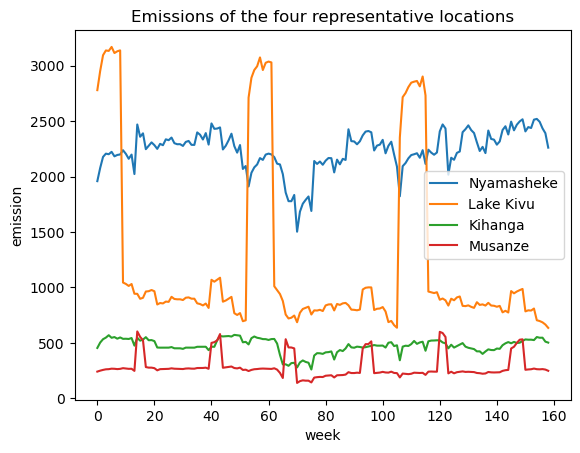

In [ ]:
for name, coord in named_loc.items():
    plt.plot(range(3*53), emission.loc[coord], label=name)
plt.title('Emissions of the four representative locations')
plt.xlabel('week')
plt.ylabel('emission')
plt.legend()
plt.show()

**Insight:**
- We don't need to predict 497 independent time series for 2022. It suffices to predict 5 basis time series, and all others can be derived.
- The huge dimensionality reduction (100 % explained variance ratio with only five components) wouldn't be possible if the measurements came from real sensors. It indicates that the emission data was generated artificially.
- I don't yet know how the information about the dimensionality reduction will help improve leaderboard scores, but I'm sure it will... 😉

# Holt-Winters exponential smoothing

There are many statistical methods specific to time series; Holt-Winters exponential smoothing is one of them.

The Holt-Winters method is based on three ideas:
1. As a first approach to predicting the next value in a time sequence, we can simply predict a weighted average of the most recent values (where the most recent value has the highest weight).
2. Holt extends this method by estimating the trend of the time series and adding the estimated trend to the weighted average of the most recent values.
3. The Holt-Winters method adds an estimation of the seasonality to the first two elements.

There are many tutorials for Holt-Winters on the Internet, for instance [here](https://otexts.com/fpp3/expsmooth.html) or [here](https://timeseriesreasoning.com/contents/holt-winters-exponential-smoothing/).

In the following piece of code, we use `statsmodels.tsa.holtwinters.ExponentialSmoothing` to predict the test emissions for four representative locations. The main hyperparameter which must be set is the length of the period (`seasonal_periods=53`).

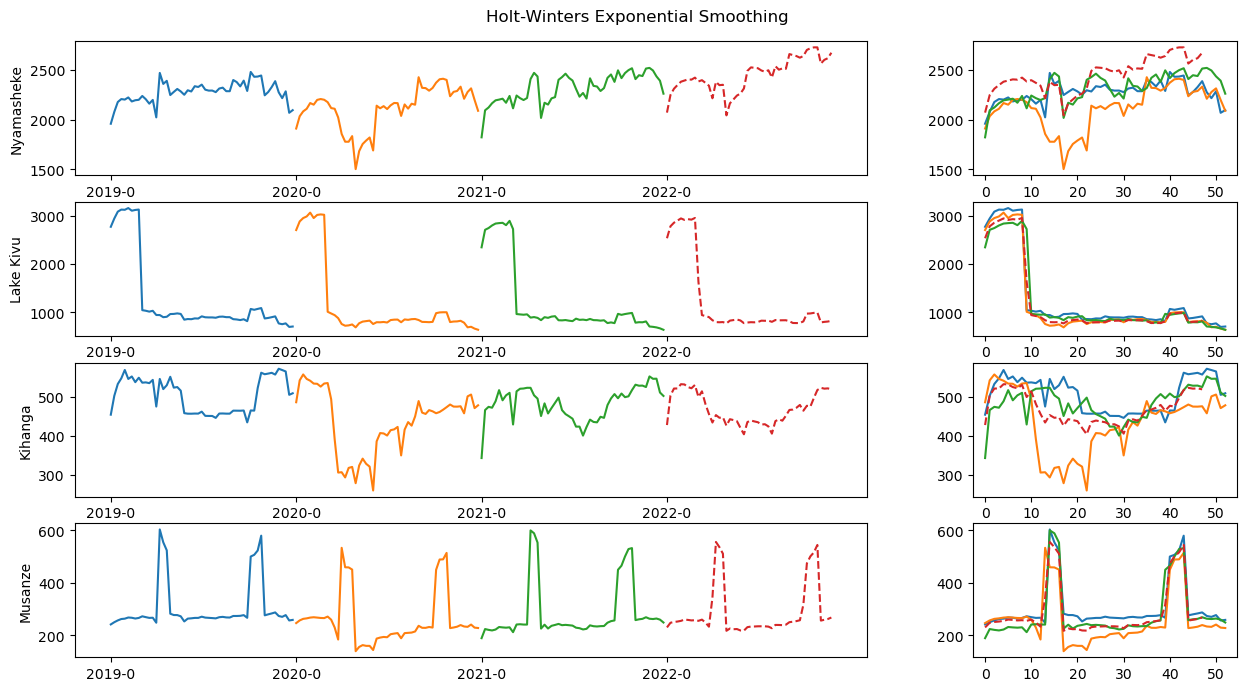

In [ ]:
emission = train.pivot(index=['year', 'week_no'], columns=['latitude', 'longitude'], values='emission')
_, axes = plt.subplots(len(named_loc), 2, width_ratios=[3, 1], figsize=(15, 8))
for (label, coord), ax in zip(named_loc.items(), axes):
    train_series = emission[coord].values
    es = statsmodels.tsa.holtwinters.ExponentialSmoothing(train_series, seasonal_periods=53, trend='add', seasonal='add')
    es = es.fit()
    test_pred = es.forecast(steps=48)
    for j in range(3):
        ax[0].plot(np.arange(j*53, j*53+53), train_series.reshape(3, 53)[j])
    ax[0].plot(np.arange(159, 159+48), test_pred, '--')
    ax[0].set_ylabel(label)
    xticks = [0, 53, 106, 159]
    ax[0].set_xticks(xticks, [f"{2019+week//53}-0" for week in xticks])

    ax[1].plot(train_series.reshape(3, 53).T)
    ax[1].plot(test_pred, '--') 
    plt.suptitle('Holt-Winters Exponential Smoothing', y=0.92)
# plt.savefig('holt-winters.png', bbox_inches='tight')
plt.show()    

# Nonnegative matrix factorization explains the low dimensionality

The target values ('emission') of our dataset are not measurements, but estimates. This fact explains why the data is low-dimensional.  Through [nonnegative matrix factorization (NMF)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html), we can understand how the data was generated.

Imagine that you want to estimate CO2 emissions for thousands of locations (the competition data shows only a subset). To get thousands of estimates efficiently, you cannot look at every location in detail, but you can simplify your work by dividing the problem into two sub-problems:
1. Estimate the emission patterns for different sectors of the economy, e.g. residential buildings, commercial buildings, ground traffic, air traffic, ... Every sector has a characteristic pattern:
  - Residential buildings emit the most CO2 during cold seasons (because of heating) or during hot seasons (because of cooling). Their emissions don't change much during the lockdown.
  - Commercial buildings emit more CO2 during the week than on week-ends.
  - Ground traffic doesn't depend on the season, but is reduced during lockdowns.
  - Air traffic might have seasonal peaks during vacation periods and is reduced during lockdowns.
2. For every location, estimate the contribution of the sectors (components) defined above:
  - A rural location has residential buildings, but few commercial buildings.
  - A city has a higher contribution from commercial buildings.
  - A freeway through a forest has ground traffic emissions, but no buildings.
  - The emissions of an airport location follow the seasonal peaks of air traffic and depend on the size of the airport.
  
The result of this process can be described by two matrices. The first matrix (let's call it B) shows the emission pattern (time series) of every sector in its rows:

<table border="1" class="dataframe" style="margin-right:auto;margin-left:0px">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>week 1</th>
      <th>week 2</th>
      <th>week 3</th>
      <th>week 4</th>
      <th>week 5</th>
      <th>...</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Residential</th>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
    </tr>
    <tr>
      <th>Commercial</th>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
    </tr>
    <tr>
      <th>Ground traffic</th>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
    </tr>
    <tr>
      <th>Air traffic</th>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
    </tr>
    <tr>
      <th>...</th>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
    </tr>
  </tbody>
</table>
<br>

The second matrix (let's call it A) shows the contributions of the components to every location:

<table border="1" class="dataframe" style="margin-right:auto;margin-left:0px">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Residential</th>
      <th>Commercial</th>
      <th>Ground traffic</th>
      <th>Air traffic</th>
      <th>...</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Location 1</th>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
    </tr>
    <tr>
      <th>Location 2</th>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
    </tr>
    <tr>
      <th>Location 3</th>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
    </tr>
    <tr>
      <th>...</th>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
    </tr>
  </tbody>
</table>
<br>

A simple matrix multiplication (X = A @ B) then gives estimates for all locations and times:

<table border="1" class="dataframe" style="margin-right:auto;margin-left:0px">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>week 1</th>
      <th>week 2</th>
      <th>week 3</th>
      <th>week 4</th>
      <th>week 5</th>
      <th>...</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Location 1</th>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
    </tr>
    <tr>
      <th>Location 2</th>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
    </tr>
    <tr>
      <th>Location 3</th>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
    </tr>
    <tr>
      <th>...</th>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
    </tr>
  </tbody>
</table>
<br>

In this competition, we got only X, but not A and B. Can we recover A and B from X? Yes, this is possible. Note that all elements of A, B and X are nonnegative (emissions are never negative, nor are the contributions of the sectors). This nonnegativity enables us to recover the matrices A and B by [nonnegative matrix factorization (NMF)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html). Nonnegative matrix factorization reduces the dataset dimensionality in a similar way as an SVD, but it makes sure that all matrix entries are nonnegative.

Above in this notebook, in the section on dimensionality reduction, I said that five dimensions were enough. For the NMF I'll use six dimensions anyway. This means that there are six sectors, A has six columns, and B has six rows. The six rows of B can be shown as time series in a diagram: 

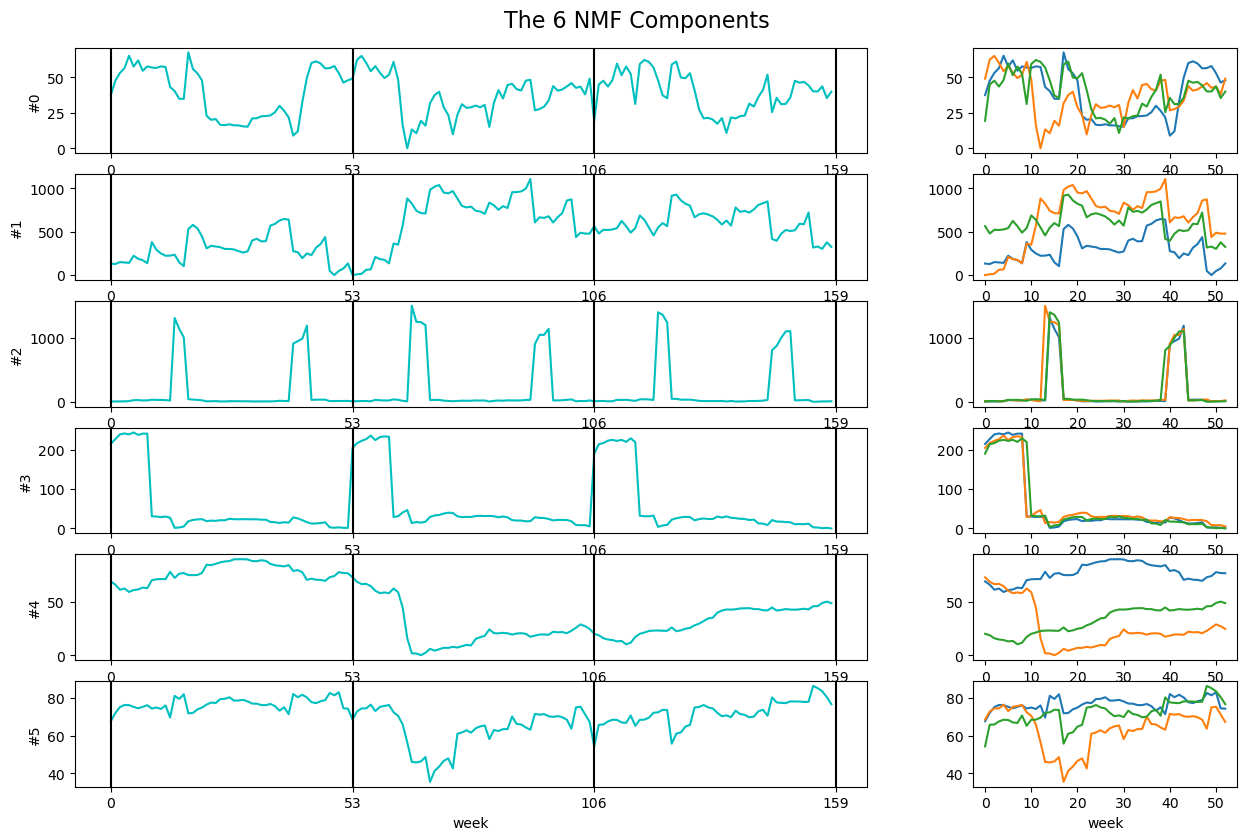

In [ ]:
X = train.pivot(index=['latitude', 'longitude'], columns=['year', 'week_no'],
                values='emission')
X.sort_index(level='latitude', ascending=False, inplace=True) # sort like test dataframe
n_components=6
nmf = NMF(n_components=n_components, solver='cd', tol=1e-8, max_iter=50000,
          random_state=1)
nmf.fit(X)
embedding = pd.DataFrame(nmf.transform(X), index=X.index)
# Matrix B = nmf.components_ = every row is the time series of a sector
# Matrix A = nmf.transform(X) = every row shows the contributions to a location

_, axes = plt.subplots(n_components, 2, width_ratios=[3, 1],
                       figsize=(15, n_components*1.6))
for i, ax in enumerate(axes):
    ax[0].plot(nmf.components_[i], color='c')
    for x in [0, 53, 106, 159]: ax[0].axvline(x, color='k')
    ax[0].set_xticks([0, 53, 106, 159])
    ax[0].set_ylabel(f"#{i}")

    ax[1].plot(nmf.components_[i].reshape(3, 53).T)
axes[n_components-1, 0].set_xlabel('week')
axes[n_components-1, 1].set_xlabel('week')
plt.suptitle('The 6 NMF Components', fontsize=16, y=0.92)
plt.show()


Notice
- Every row has another seasonal pattern.
- Components \#2 and \#3 are periodic — they are not affected by Covid.
- Component \#1 has an inverse Covid effect: The emissions go up in 2020.

**Insight**:
- Sometimes an NMF gives more interpretable results than an SVD.

The information about the estimation process has been taken from https://carbonmonitor-graced.com/methods.html#background (which is acknowledged on the competition homepage).


# Hiding behind seasonality: the Covid recovery curve

Let's implement another time series model. For the model, I assume that every series of emission values in this competition is a sum of three components:
1. a seasonal component which repeats every year (green in the diagram)
2. a Covid shock in week 63, followed by a gradual recovery process (red in the diagram)
3. a bit of noise (as always) (included in the red line)

Extrapolation of the components into 2022 is straightforward:
1. The seasonal component doesn't change.
2. The Covid recovery process is modeled as an exponential decay with obvious continuation.
3. The noise doesn't need to be extrapolated.

Key to the model of course is that you can separate the seasonal component from the Covid recovery component.

I'll apply this model to the six components of the nonnegative matrix decomposition above. The diagram shows the decomposition of each NMF time series into a seasonal component (green) with a period of 53 weeks and a Covid (+ noise) component (red). Every target value is a sum of red and green, so if you can predict red and green, you're done:

#0: a =     1   T =     196   tr-loss =    74
#1: a =   504   T =     136   tr-loss =  9013
#2: a =     4   T = 1000000   tr-loss =   123
#3: a =     7   T =      29   tr-loss =     3
#4: a =   -80   T =      70   tr-loss =    19
#5: a =   -30   T =      19   tr-loss =    15


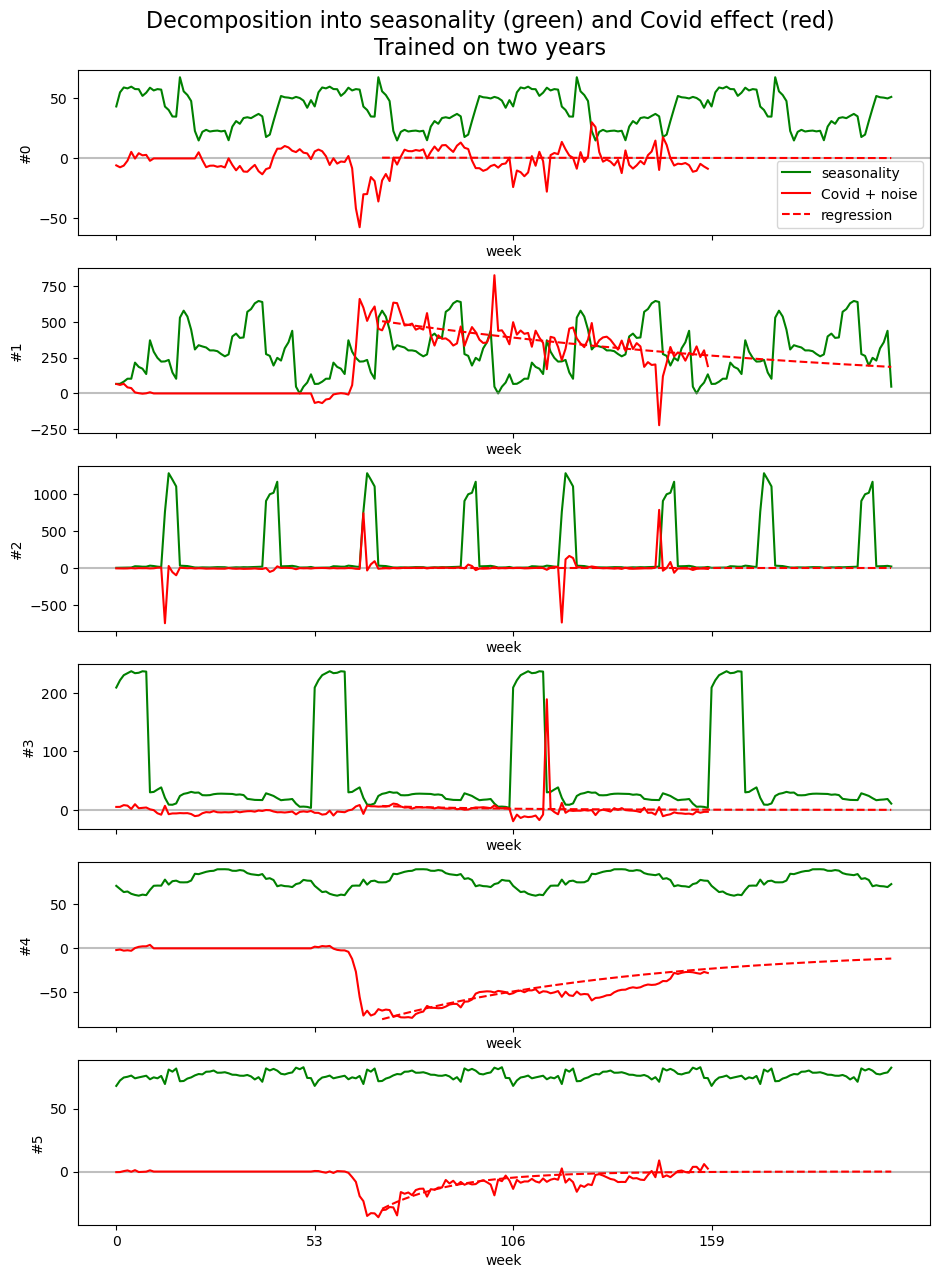

# Training RMSE: 6.97
# Validation RMSE: 17.79


In [ ]:
def decompose_seasonal_covid(test_start):
    """Decompose the NMF components into seasonality and Covid effect.
    Print the coefficients of the recovery function.
    Plot decomposition and forecast.
    Compute RMSE or write submission file depending on test_start.
    
    Weeks [:test_start] are used for training, weeks[teststart:] are used for validation.
    """
    assert nmf.components_.shape[1] == 159 # 159 weeks in training data
    assert test_start == 106 or test_start == 159
    n_components = len(nmf.components_)

    # For determining the seasonality, the following weeks are considered outliers:
    if n_components == 6:
        covid_weeks = {0: np.arange(63, 75),
                       1: np.arange(63, 159),
                       2: [],
                       3: [],
                       4: np.arange(63, 159),
                       5: np.arange(63, 159)}

    z_tr_pred = np.full((test_start-71, n_components), np.nan) # part of 2020 and 2021
    z_va_pred = np.full((53, n_components), np.nan) # 53 weeks in 2021
    z_te_pred = np.full((49, n_components), np.nan) # 49 weeks in 2022
    _, axes = plt.subplots(n_components, 1, figsize=(11, n_components*2.5),
                           sharex=True, squeeze=False)
    for i, ax in enumerate(axes[:n_components]):
        # Get the time series (blue)
        comp = nmf.components_[i].copy()
    #     ax[0].plot(comp, 'b')

        # Determine the seasonality (green) based on the unaffected regions
        comp_unaffected = comp.copy()
        comp_unaffected[covid_weeks[i]] = np.nan
        comp_unaffected = comp_unaffected[:test_start]
        comp_unaffected = comp_unaffected.reshape(-1, 53)
        seasonality = np.nanmean(comp_unaffected, axis=0)
        seasonality = np.tile(seasonality, 4)
        ax[0].plot(seasonality[:159+49], 'g', label='seasonality')

        # Determine and plot the training data without seasonality (red)
        comp -= seasonality[:len(comp)]
        ax[0].axhline(0, color='gray', alpha=0.5)
        ax[0].plot(comp.ravel(), 'r', label='Covid + noise')

        # Fit an exponential curve to the Covid recovery region
        # and plot it (red dashed line)
        def obj(x):
            """
            Loss function to be minimized

            x[0] = a = emission at week 71
            x[1] = T = time constant for exponential decay
            returns: training mse
            """
            a, T = x
            y_pred = a * np.exp(- np.arange(0, test_start-71) / T)
            loss = mean_squared_error(comp[71:test_start], y_pred)
            return loss

        x0 = np.array([0, 40]) # initial a and T
        bounds = ((-1e4, 1e4), (15, 1e6)) # T must be > 0
        res = minimize(obj, x0, method='Powell', bounds=bounds, tol=0.0001)
        a, T = res.x # optimal values
        print(f"#{i}: a = {a:5.0f}   T = {T:7.0f}   tr-loss = {res.fun:5.0f}")
        ax[0].plot(np.arange(71, 159+49), a * np.exp(- np.arange(0, 159+49-71) / T),
                   'r--', label='regression')

        # Compute predictions for the component as sum of exponential regression line and seasonality
        z_pred = a * np.exp(- np.arange(0, 159+49-71) / T) + seasonality[71:159+49]

        # Predict the training labels
        z_tr_pred[:, i] = z_pred[:test_start-71]

        # Predict and plot the final year (blue dashed line)
        z_va_pred[:, i] = z_pred[106-71:159-71]
        z_te_pred[:, i] = z_pred[159-71:159+49-71]
    #     ax[0].plot(np.arange(71, 159+49), z_pred, 'b--')

        ax[0].set_xticks([0, 53, 106, 159])
        ax[0].set_ylabel(f"#{i}")
        ax[0].set_xlabel(f"week")

    # Finish the plot
    axes[0, 0].legend()
    plt.suptitle('Decomposition into seasonality (green) and Covid effect (red)\n' +
                 ('Trained on two years' if test_start == 106 else 'Trained on three years'),
                 fontsize=16, y=0.92)
#     plt.savefig(f'seasonal+covid-{test_start//53}')
    plt.show()
    
    # Compute training score (RMSE)
    y_tr_pred = embedding.values @ z_tr_pred.T # inverse of NMF, shape (479, test_start-71)
    rmse = mean_squared_error(X.values[:,71:test_start].ravel(), y_tr_pred.ravel(), squared=False)
    print(f"{Fore.GREEN}{Style.BRIGHT}# Training RMSE: {rmse:.2f}{Style.RESET_ALL}")
    
    if test_start == 106: 
        # Compute validation score (RMSE)
        y_va_pred = embedding.values @ z_va_pred.T # inverse of NMF, shape (479, 53)
        rmse = mean_squared_error(X.values[:,test_start:].ravel(), y_va_pred.ravel(), squared=False)
        print(f"{Fore.GREEN}{Style.BRIGHT}# Validation RMSE: {rmse:.2f}{Style.RESET_ALL}")
    else:
        # Create submission
        y_te_pred = embedding.values @ z_te_pred.T # inverse of NMF, shape (479, 49)
        submission = pd.Series(y_te_pred.ravel(), name='emission', index=test.index)
        submission.to_csv('submission.csv')
        display(submission)

decompose_seasonal_covid(test_start=106) # 106 weeks = 2 years


The diagram above uses 2019 and 2020 as training data and validates with 2021, giving a validation RMSE of 17.79 (better than the baseline model, which has RMSE = 19.77 for 2021). We now refit the model to the complete training data and generate a submission file.

#0: a =    -3   T =      15   tr-loss =    59
#1: a =   520   T =     119   tr-loss =  9312
#2: a =    -4   T =      21   tr-loss =  6948
#3: a =     8   T =      24   tr-loss =   197
#4: a =   -76   T =     108   tr-loss =    35
#5: a =   -25   T =      30   tr-loss =    18


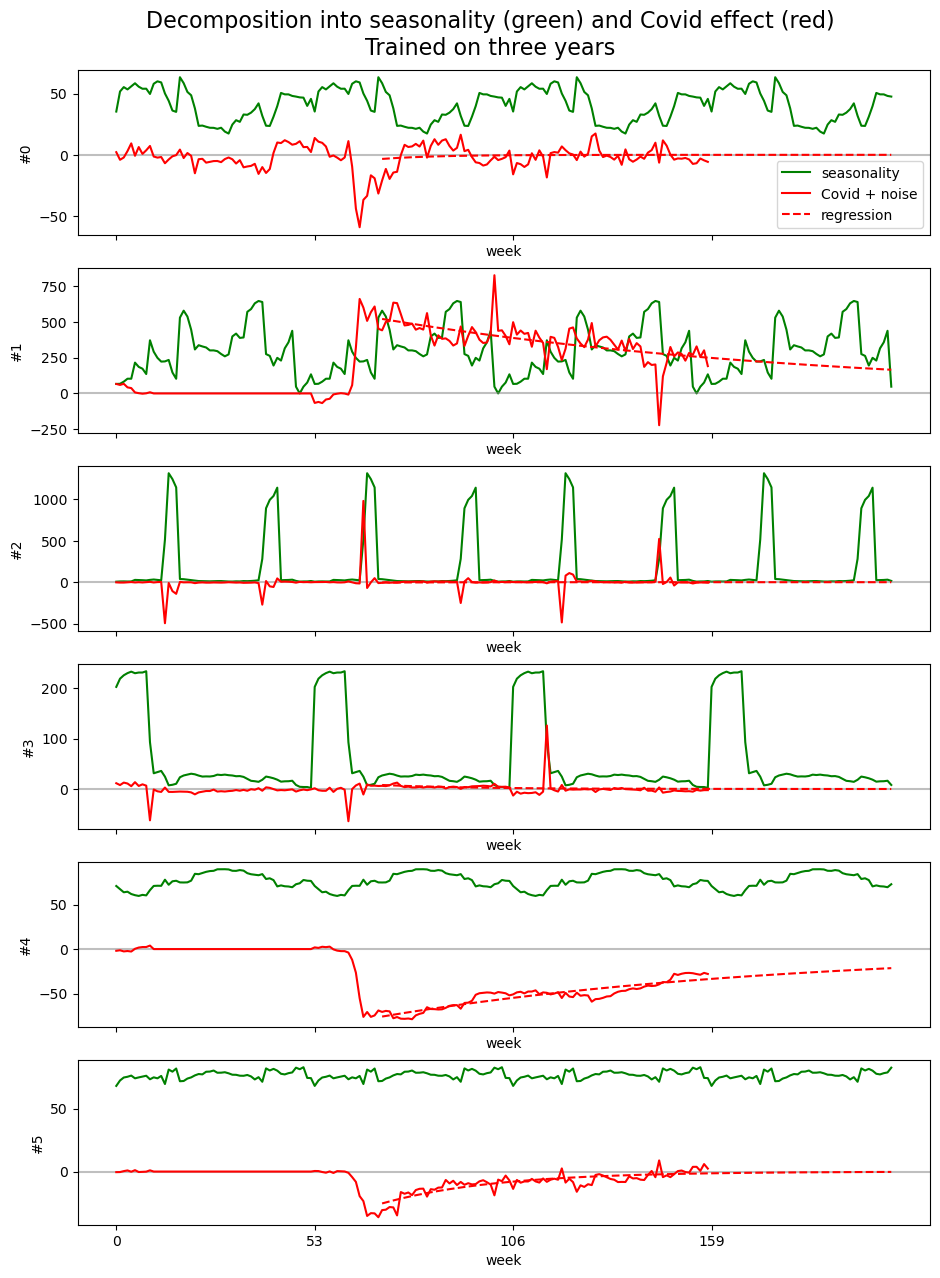

# Training RMSE: 10.71


ID_LAT_LON_YEAR_WEEK
ID_-0.510_29.290_2022_00     3.856273
ID_-0.510_29.290_2022_01     4.116231
ID_-0.510_29.290_2022_02     4.250570
ID_-0.510_29.290_2022_03     4.299439
ID_-0.510_29.290_2022_04     4.346454
                              ...    
ID_-3.299_30.301_2022_44    29.328652
ID_-3.299_30.301_2022_45    29.654031
ID_-3.299_30.301_2022_46    30.179573
ID_-3.299_30.301_2022_47    30.722821
ID_-3.299_30.301_2022_48    28.916335
Name: emission, Length: 24353, dtype: float64

In [ ]:
decompose_seasonal_covid(test_start=159) # 159 weeks = 3 years
